<a href="https://colab.research.google.com/github/reesha-rsh/MLb4/blob/main/Homework/Homework_7_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/MLb4/EDA Titanic/train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Make a basic EDA, write briefly a few conclusions that, in your opinion, will affect the model / model validation / metrics

I am removing text features that I think will not be usefull for the models. Also One-Hot Encoding for Sex. Most probably the Sex affects the result the most.

In [82]:
data_cleaned = data

In [83]:
useless_features = ['Name','Ticket','Cabin','Embarked']

In [84]:
data_cleaned = data_cleaned.drop(columns = useless_features)
data_cleaned

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000
887,888,1,1,female,19.0,0,0,30.0000
888,889,0,3,female,NaN,1,2,23.4500
889,890,1,1,male,26.0,0,0,30.0000


In [85]:
# generate binary values using get_dummies
data_cleaned = pd.get_dummies(data_cleaned, columns=['Sex'],prefix=["Sex"])
data_cleaned

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,1,0,3,22.0,1,0,7.2500,0,1
1,2,1,1,38.0,1,0,71.2833,1,0
2,3,1,3,26.0,0,0,7.9250,1,0
3,4,1,1,35.0,1,0,53.1000,1,0
4,5,0,3,35.0,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,0,1
887,888,1,1,19.0,0,0,30.0000,1,0
888,889,0,3,NaN,1,2,23.4500,1,0
889,890,1,1,26.0,0,0,30.0000,0,1


In [86]:
# Check for NaN values in the DataFrame
nan_mask = data_cleaned.isnull()

# Print the DataFrame with boolean values (True for NaN, False for non-NaN)
print(nan_mask)

# Count the number of NaN values in each column
nan_count_per_column = data_cleaned.isnull().sum()

# Print the number of NaN values per column
print(nan_count_per_column)

     PassengerId  Survived  Pclass    Age  SibSp  Parch   Fare  Sex_female  \
0          False     False   False  False  False  False  False       False   
1          False     False   False  False  False  False  False       False   
2          False     False   False  False  False  False  False       False   
3          False     False   False  False  False  False  False       False   
4          False     False   False  False  False  False  False       False   
..           ...       ...     ...    ...    ...    ...    ...         ...   
886        False     False   False  False  False  False  False       False   
887        False     False   False  False  False  False  False       False   
888        False     False   False   True  False  False  False       False   
889        False     False   False  False  False  False  False       False   
890        False     False   False  False  False  False  False       False   

     Sex_male  
0       False  
1       False  
2       False  

In [87]:
age_median = data_cleaned['Age'].median()
age_median

28.0

In [88]:
data_cleaned['Age'] = data_cleaned['Age'].fillna(age_median)


In [89]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned.drop('Survived', axis=1), data_cleaned['Survived'], test_size=0.15, random_state=42, stratify=data['Survived'])

3. Describe your validation approach and metrics for this dataset.

*   Validation approach: We have a small amount of data so I will use a **K Fold** method
*   Metric: I plan to optimize **fbeta score** with beta 0.1 to give more weight for precision, thus minimizing false positives - reducing the prediction that a passenger survived when he actually did not.



4. Train and tune logistic regression (optimise the metric).

In [90]:
titanic_features = X_train[['Pclass',	'Age',	'SibSp',	'Parch',	'Fare',	'Sex_female',	'Sex_male']]
titanic_label = y_train

In [91]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, fbeta_score
from sklearn import metrics

# Define the logistic regression model
classifier = LogisticRegression()

params = dict(C=[100, 10, 1, 0.1, 0.01, 0.001, 0.0001])

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the custom scoring function with the desired beta value
beta = 0.1
custom_scorer = make_scorer(fbeta_score, beta=beta)

# Initialize the GridSearchCV object with the custom scoring function
grid_search = GridSearchCV(classifier, param_grid=params, scoring=custom_scorer, cv=skf)

# Perform grid search with K-fold cross-validation to find the best hyperparameters
grid_search.fit(titanic_features, titanic_label)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the model with the best hyperparameters on the full data
best_model.fit(titanic_features, titanic_label)

# Make predictions on the test set
y_pred = best_model.predict(titanic_features)

# Calculate the F-beta score with the specified beta value
fbeta = fbeta_score(titanic_label, y_pred, beta=beta)

print("Best Hyperparameters:", best_params)
print("F-beta Score (beta={}): {:.4f}".format(beta, fbeta))
print(metrics.classification_report(titanic_label, y_pred))
print(metrics.confusion_matrix(titanic_label, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Hyperparameters: {'C': 0.01}
F-beta Score (beta=0.1): 0.8384
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       466
           1       0.84      0.52      0.64       291

    accuracy                           0.78       757
   macro avg       0.80      0.73      0.74       757
weighted avg       0.79      0.78      0.76       757

[[438  28]
 [140 151]]


5. Do the same with a decision tree.

In [92]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, fbeta_score



# Define the DecisionTreeClassifier model
classifier = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search over
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10, 20],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Initialize the StratifiedKFold object for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the beta value for F-beta score (e.g., beta = 0.1 to prioritize precision)
beta = 0.1

# Create a custom scorer with the specified beta value to optimize precision in F-beta score
custom_scorer = make_scorer(fbeta_score, beta=beta)

# Initialize the GridSearchCV object with the DecisionTreeClassifier, hyperparameter grid, and custom scorer
grid_search = GridSearchCV(classifier, param_grid, scoring=custom_scorer, cv=skf)

# Perform grid search to find the best hyperparameters
grid_search.fit(titanic_features, titanic_label)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Optionally, you can evaluate the model on the full data using the F-beta score with beta=0.1
y_pred = best_model.predict(titanic_features)
fbeta = fbeta_score(titanic_label, y_pred, beta=beta)
print("F-beta Score (beta={}): {:.4f}".format(beta, fbeta))

print(metrics.classification_report(titanic_label, y_pred))
print(metrics.confusion_matrix(titanic_label, y_pred))


Best Hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
F-beta Score (beta=0.1): 0.9437
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       466
           1       0.95      0.48      0.64       291

    accuracy                           0.79       757
   macro avg       0.85      0.73      0.75       757
weighted avg       0.83      0.79      0.77       757

[[459   7]
 [150 141]]




6. Visualize the decision tree and interpret the model (describe the most important features, whether the splits are logical, etc.)

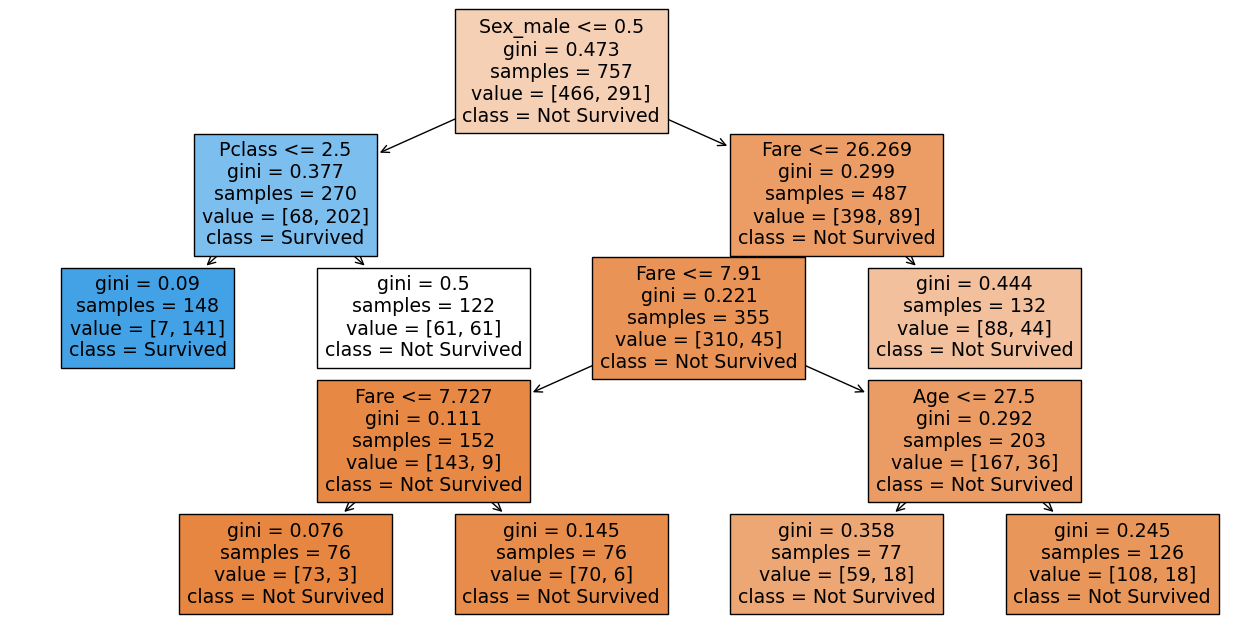

In [93]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# Visualize the decision tree splits
plt.figure(figsize=(16, 8))
plot_tree(best_model, filled=True, feature_names=titanic_features.columns, class_names=['Not Survived', 'Survived'])
plt.show()

Looks like the most imporant features are Sex and Pclass. While testing there were other features but these are top 2 always.

I expected the Age to be more important.

The splits look logical: First we check for Sex. Women has more chance to survive than men





7. If there is a test dataset, then make predictions on it and compare the result on lb with what you've got on validation (if there is no test dataset, then create it yourself, before training the model, separate 15-20% from the dataset and it will be your test). on the test, you run the model only once to find out the final result.

In [94]:
X_test = X_test[['Pclass',	'Age',	'SibSp',	'Parch',	'Fare',	'Sex_female',	'Sex_male']]

In [95]:
y_pred = best_model.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=beta)
print("F-beta Score (beta={}): {:.4f}".format(beta, fbeta))

F-beta Score (beta=0.1): 0.8974
